In [1]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star_orig import astar
import pickle
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
from magic import ordinator
import cv2

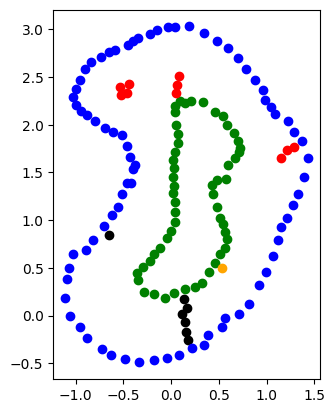

In [2]:
with open(r"SLAM20240124_162059.pickle", "rb") as input_file:
# with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:

    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']
ids = np.array(ids)
robot_pose=e['robot_pose']

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.show()


positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)
mask_obstacle = (ids % 3 == 1) & (ids >= 100) & (ids <= 1000)
mask_start_line = (ids < 100)


ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]
positions_obstacle = positions_array[mask_obstacle]
positions_start_line = positions_array[mask_start_line]

In [3]:
pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext,max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step=0.03
max_x=np.max(external_ordered[:,0])
max_y=np.max(external_ordered[:,1])
min_x=np.min(external_ordered[:,0])
min_y=np.min(external_ordered[:,1])
delta_x=max_x-min_x
delta_y=max_y-min_y
center_x=min_x+delta_x/2
center_y=min_y+delta_y/2

n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)


x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask = np.array([[ not ext_ordered_poly.contains(Point(x[i], y[j])) or int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

In [4]:
mask_line_obs=np.zeros_like(mask, dtype=bool)
for x_i,y_i in np.vstack((positions_start_line, positions_obstacle)):
    mask_line_obs += np.array([[Point(x_i,y_i).buffer(0.1).contains(Point(x[i], y[j]))
                for i in range(len(x))] for j in range(len(y))])

In [5]:
mask=mask+mask_line_obs

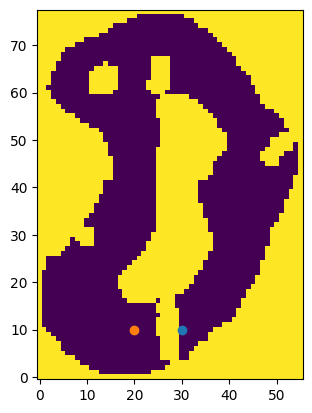

In [6]:
plt.imshow(mask, origin='lower')
plt.scatter(30,10)
plt.scatter(20,10)

In [7]:
astar(1-mask, (30,10),(40,40))

False